In [1]:
import joblib
import pandas as pd
from matplotlib_venn import venn3_unweighted
import seaborn as sns
import matplotlib.pyplot as plt

# 한글 폰트 설정 (Windows 기본 폰트)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

### venn_stability

ft-transformer 모델은 전처리 방식이 달라, 전처리 방식이 같고,
r2값이 가장 높은 머신러닝 모델 3개 사용

In [ ]:
# ✅ 모델 불러오기
models = joblib.load("./model/VIF_ML_models.pkl")

# ✅ 모델별 중요 변수 추출

## XGBoost
xgb_model = models["XGBoost"]
xgb_importance = xgb_model.get_booster().get_score(importance_type='gain')  # or 'weight', 'cover'
fi_xgb = [k for k, _ in sorted(xgb_importance.items(), key=lambda x: x[1], reverse=True)[:10]]

## LightGBM
lgbm_model = models["LightGBM"]
lgbm_importance = lgbm_model.feature_importances_
lgbm_features = lgbm_model.feature_name_
df_lgbm = pd.DataFrame({"feature": lgbm_features, "importance": lgbm_importance})
fi_lgbm = df_lgbm.sort_values("importance", ascending=False)["feature"].head(10).tolist()

## CatBoost
cat_model = models["CatBoost"]
cat_importance = cat_model.get_feature_importance()
cat_features = cat_model.feature_names_
df_cat = pd.DataFrame({"feature": cat_features, "importance": cat_importance})
fi_cat = df_cat.sort_values("importance", ascending=False)["feature"].head(10).tolist()

# ✅ 최종 리스트
fi_list = [fi_xgb, fi_lgbm, fi_cat]

# 확인
for i, fi in enumerate(fi_list, 1):
    print(f"[Fold {i}] Top-10 Features:", fi)


[Fold 1] Top-10 Features: ['시도명_서울특별시', '용도지역1_일반상업지역', '지번구분_2', '용도지구_방화지구', '기타제한_허가구역', '용도지역1_제3종일반주거지역', '도로교통_광대소각', '시도명_부산광역시', '용도지역1_준주거지역', '면적']
[Fold 2] Top-10 Features: ['면적', '용도지역1_일반상업지역', '도로교통_광대소각', '시도명_서울특별시', '용도지역1_제2종일반주거지역', '도로교통_중로각지', '용도지구_시가지경관지구', '용도지구_방화지구', '도로교통_중로한면', '기타제한_군사기지및군사시설보호구역_비행안전구역']
[Fold 3] Top-10 Features: ['시도명_서울특별시', '용도지역1_일반상업지역', '면적', '용도지구_방화지구', '도로교통_광대소각', '용도지역1_제3종일반주거지역', '기타제한_허가구역', '시도명_부산광역시', '용도지역1_준주거지역', '형상명_세로장방형']


c:\Users\jeongbin\Projects\LandValue_project\venv\lib\site-packages\matplotlib_venn\_util.py:62: UserWarning: venn3_unweighted is deprecated. Use venn3 with the appropriate layout_algorithm instead.
  warnings.warn(


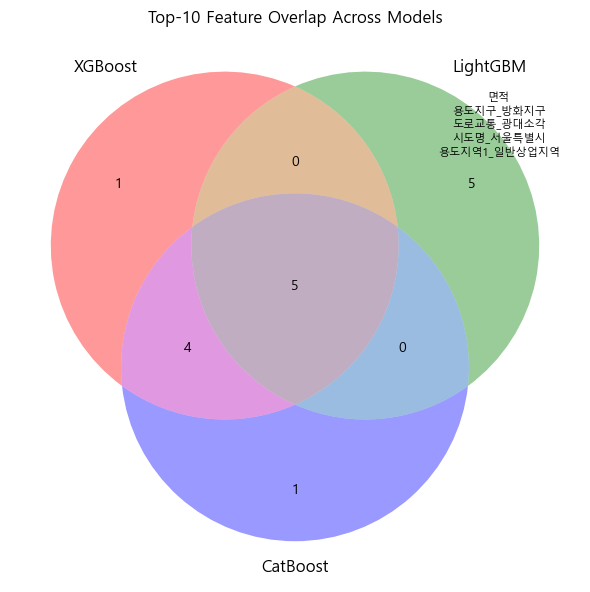

In [10]:
# 교집합 변수 추출
common_vars = set(fi_xgb) & set(fi_lgbm) & set(fi_cat)
text_label = "\n".join(list(common_vars))


v1, v2, v3 = set(fi_list[0]), set(fi_list[1]), set(fi_list[2])
s100 = len(v1 - v2 - v3)
s010 = len(v2 - v1 - v3)
s110 = len((v1 & v2) - v3)
s001 = len(v3 - v1 - v2)
s101 = len((v1 & v3) - v2)
s011 = len((v2 & v3) - v1)
s111 = len(v1 & v2 & v3)

# Venn 다이어그램
plt.figure(figsize=(6, 6))
venn3_unweighted(
    subsets=(s100, s010, s110, s001, s101, s011, s111),
    set_labels=("XGBoost", "LightGBM", "CatBoost")
)
plt.title("Top-10 Feature Overlap Across Models")

# 중앙 교집합 위치에 변수 이름 추가 (x=0.5, y=0.32 등으로 조정)
plt.text(0.5, 0.32, text_label, ha='center', fontsize=8)

plt.tight_layout()
plt.savefig("venn_stability_with_labels.png", bbox_inches="tight")
plt.show()



In [2]:
import pickle
with open("./split_data/VIF_split_data_3way.pkl", "rb") as f:
    X_train, X_valid, X_test, y_train, y_valid, y_test = pickle.load(f)

### 덴드로그램

In [15]:
# 원-핫 인코딩된 데이터프레임: onehot_df
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

def plot_dendrogram_from_onehot(df, method='ward', top_n=None):
    if top_n:
        # 상관관계 높은 top-n 변수만 사용
        corr_matrix = df.corr().abs()
        corr_sum = corr_matrix.sum().sort_values(ascending=False)
        selected_cols = corr_sum.head(top_n).index
        df = df[selected_cols]
    
    # 상관계수 → 거리행렬
    distance = 1 - df.corr().abs()
    Z = linkage(distance, method=method)

    plt.figure(figsize=(12, 8))
    dendrogram(Z, labels=df.columns, orientation='right')
    plt.title("Dendrogram of One-Hot Encoded Features")
    plt.xlabel("Distance (1 - |correlation|)")
    plt.tight_layout()
    plt.show()


C:\Users\jeongbin\AppData\Local\Temp\ipykernel_27568\3700652264.py:17: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance, method=method)


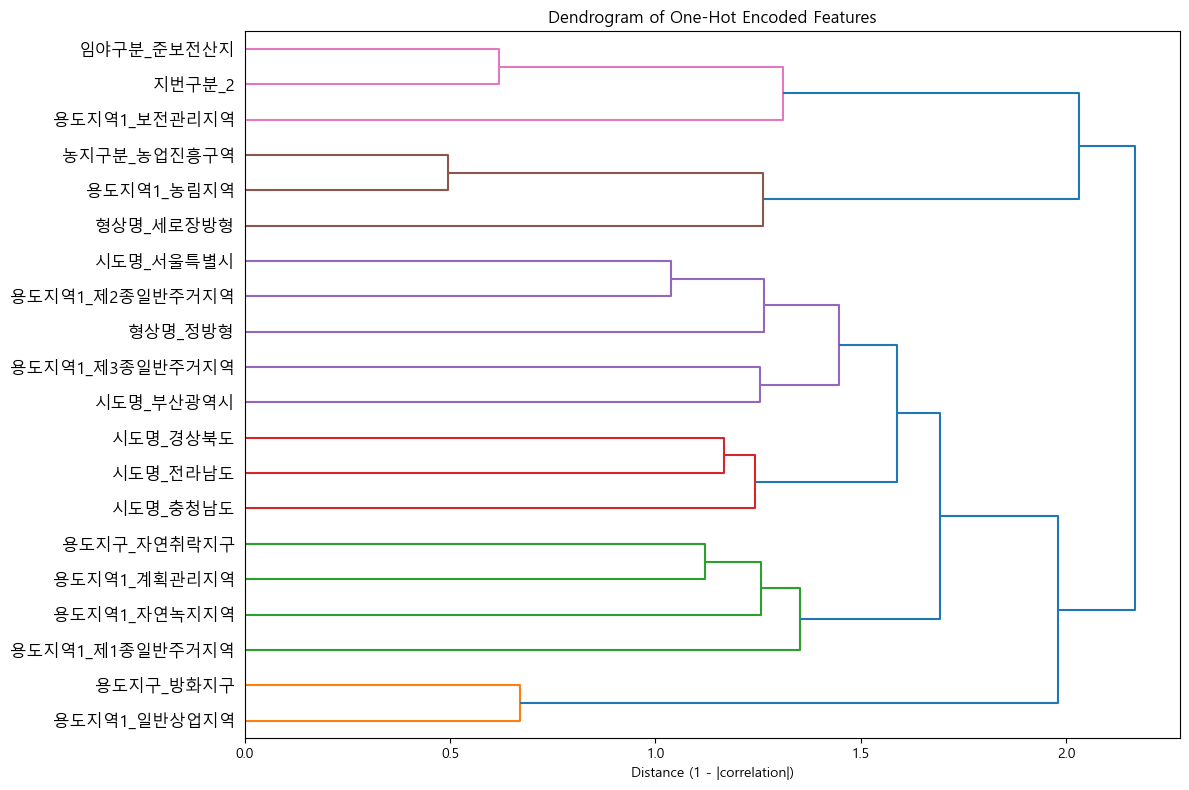

In [ ]:
# 상위 20개 변수를 이용한 덴드로그램
plot_dendrogram_from_onehot(X_train, top_n=20)


### sensitivity_weight

In [9]:
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os

# ✅ SMAPE 수식 정의
def smape(y_true, y_pred):
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 100 * np.mean(diff)

# ✅ 배치 예측 함수 정의
def predict_in_batches(model, X, batch_size=10000):
    preds = []
    for i in range(0, X.shape[0], batch_size):
        batch = X[i:i+batch_size]
        batch_pred = model.predict(batch)
        preds.extend(batch_pred)
    return np.array(preds)

# ✅ 정규화 정보
y_min = 216.0
y_max = 165300000.0

# ✅ 모델 불러오기
models = joblib.load("./model/VIF_ML_models.pkl")  # {XGB, LGBM, CatBoost}

# ✅ 결과 저장용 리스트
rows = []

# ✅ 성능 계산
for name, model in models.items():
    y_pred = predict_in_batches(model, X_test, batch_size=2000)

    # ✅ 정규화 역변환
    y_pred_inverse = y_pred * (y_max - y_min) + y_min
    y_test_inverse = y_test * (y_max - y_min) + y_min

    # ✅ 지표 계산
    mse = mean_squared_error(y_test_inverse, y_pred_inverse)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
    smape_val = smape(y_test_inverse, y_pred_inverse)
    r2 = r2_score(y_test_inverse, y_pred_inverse)

    rows.append({
        "Model": name,
        "MSE": round(mse, 4),
        "RMSE": round(rmse, 4),
        "MAE": round(mae, 4),
        "SMAPE": round(smape_val, 4),
        "R2": round(r2, 4)
    })

# ✅ DataFrame 생성 및 저장
df_metrics = pd.DataFrame(rows)
os.makedirs("output/only_adversarial", exist_ok=True)
# df_metrics.to_csv("output/only_adversarial/combined_results.csv", index=False)

print(df_metrics)



                   Model           MSE          RMSE          MAE    SMAPE  \
0               CatBoost  2.655140e+12  1.629460e+06  355433.4802  78.4608   
1               LightGBM  2.691737e+12  1.640651e+06  352803.1062  79.5345   
2                XGBoost  2.685592e+12  1.638777e+06  350772.4299  77.6705   
3                HistGBR  2.703885e+12  1.644349e+06  362498.8520  82.9306   
4  RandomForestRegressor  2.760902e+12  1.661596e+06  394696.9088  86.2796   

       R2  
0  0.6285  
1  0.6233  
2  0.6242  
3  0.6216  
4  0.6137  


Tabnet 

In [10]:
from pytorch_tabnet.tab_model import TabNetRegressor

loaded_model = TabNetRegressor()
loaded_model.load_model("./model/best_VIF(X)_tabnet_model.zip")

c:\Users\jeongbin\Projects\LandValue_project\venv\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [11]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ✅ SMAPE 수식 정의
def smape(y_true, y_pred):
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 100 * np.mean(diff)

# ✅ 정규화 기준
y_min = 216.0
y_max = 165300000.0

# ✅ 예측
y_pred = loaded_model.predict(X_test.values).squeeze()  # TabNet은 .squeeze() 필요할 수 있음

# ✅ 역정규화
y_pred_inverse = y_pred * (y_max - y_min) + y_min
y_test_inverse = y_test * (y_max - y_min) + y_min

# ✅ 성능 평가
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
smape_val = smape(y_test_inverse, y_pred_inverse)
r2 = r2_score(y_test_inverse, y_pred_inverse)

# ✅ 결과 출력
print("📊 TabNet 평가 결과 (역정규화 기준)")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"SMAPE: {smape_val:.4f}")
print(f"R2: {r2:.4f}")


📊 TabNet 평가 결과 (역정규화 기준)
MSE: 3163553988253.6826
RMSE: 1778638.2398
MAE: 503727.0554
SMAPE: 155.3254
R2: 0.5573


FTTransformer

In [15]:
from rtdl import FTTransformer
from torch.serialization import safe_globals
import torch 

# ✅ 데이터 로딩
with open("./split_data/VIF_split_data_fn_transformer.pkl", "rb") as f:
    X_train_tensor, X_valid_tensor, X_test_tensor, y_train_tensor, y_valid_tensor, y_test_tensor = pickle.load(f)
    
with safe_globals([FTTransformer]):
    ft_model = torch.load("./model/VIF_fttransformer_trained.pt", weights_only=False, map_location=torch.device("cpu"))
ft_model.eval()

FTTransformer(
  (feature_tokenizer): FeatureTokenizer(
    (cat_tokenizer): CategoricalFeatureTokenizer(
      (embeddings): Embedding(90, 64)
    )
  )
  (cls_token): CLSToken()
  (transformer): Transformer(
    (blocks): ModuleList(
      (0): ModuleDict(
        (attention): MultiheadAttention(
          (W_q): Linear(in_features=64, out_features=64, bias=True)
          (W_k): Linear(in_features=64, out_features=64, bias=True)
          (W_v): Linear(in_features=64, out_features=64, bias=True)
          (W_out): Linear(in_features=64, out_features=64, bias=True)
          (dropout): Dropout(p=0.1971837206675287, inplace=False)
        )
        (ffn): FFN(
          (linear_first): Linear(in_features=64, out_features=1024, bias=True)
          (activation): ReGLU()
          (dropout): Dropout(p=0.1971837206675287, inplace=False)
          (linear_second): Linear(in_features=512, out_features=64, bias=True)
        )
        (attention_residual_dropout): Dropout(p=0.19718372066752

In [19]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ✅ SMAPE 함수 정의
def smape(y_true, y_pred):
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 100 * np.mean(diff)

# ✅ 역정규화 기준
y_min = 216.0
y_max = 165300000.0

# ✅ 배치 사이즈 설정
batch_size = 1024
n_samples = X_test_tensor.size(0)

# ✅ 예측 수행
ft_model.eval()
preds = []

cat_indices = list(range(X_test_tensor.shape[1]))

with torch.no_grad():
    for i in range(0, n_samples, batch_size):
        xb = X_test_tensor[i:i+batch_size]
        x_cat = xb[:, cat_indices].long()
        pred = ft_model(None, x_cat)
        preds.append(pred.cpu().numpy())

# ✅ 연결 및 역정규화
y_pred = np.concatenate(preds).squeeze()
y_test = y_test_tensor.cpu().numpy().squeeze()

y_pred_inverse = y_pred * (y_max - y_min) + y_min
y_test_inverse = y_test * (y_max - y_min) + y_min

# ✅ 성능 지표 계산
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
smape_val = smape(y_test_inverse, y_pred_inverse)
r2 = r2_score(y_test_inverse, y_pred_inverse)

# ✅ 출력
print("📊 FTTransformer 평가 결과 (범주형 입력 기반)")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"SMAPE: {smape_val:.4f}")
print(f"R2: {r2:.4f}")

📊 FTTransformer 평가 결과 (범주형 입력 기반)
MSE: 2388899921920.0000
RMSE: 1545606.6517
MAE: 321539.3125
SMAPE: 77.3925
R2: 0.6657


In [21]:
tabnet_row = {
    "Model": "TabNet",
    "MSE": round(3163553988253.6826, 4),
    "RMSE": round(1778638.2398, 4),
    "MAE": round(503727.0554, 4),
    "SMAPE": round(155.3254, 4),
    "R2": round(0.5573, 4)
}

fttransformer_row = {
    "Model": "FTTransformer",
    "MSE": round(2388899921920.0000, 4),
    "RMSE": round(1545606.6517, 4),
    "MAE": round(321539.3125, 4),
    "SMAPE": round(77.3925, 4),
    "R2": round(0.6657, 4)
}


In [23]:
df_metrics = pd.concat([
    df_metrics,
    pd.DataFrame([tabnet_row, fttransformer_row])
], ignore_index=True)


In [26]:
df_metrics

,Model,MSE,RMSE,MAE,SMAPE,R2
0,CatBoost,"2,655,139,549,768.8608","1,629,459.8951","355,433.4802",78.4608,0.6285
1,LightGBM,"2,691,736,714,236.7881","1,640,651.3079","352,803.1062",79.5345,0.6233
2,XGBoost,"2,685,591,687,035.6230","1,638,777.4977","350,772.4299",77.6705,0.6242
3,HistGBR,"2,703,885,058,765.0347","1,644,349.4333","362,498.8520",82.9306,0.6216
4,RandomForestRegressor,"2,760,901,539,352.3257","1,661,596.0819","394,696.9088",86.2796,0.6137
5,TabNet,"3,163,553,988,253.6826","1,778,638.2398","503,727.0554",155.3254,0.5573
6,FTTransformer,"2,388,899,921,920.0000","1,545,606.6517","321,539.3125",77.3925,0.6657


In [4]:
pd.set_option('display.float_format', '{:,.4f}'.format)


In [27]:
df_metrics.to_csv("all_results.csv", index=False)

In [2]:
no_adv=pd.read_csv('all_results.csv')
adv_ft=pd.read_csv('adv_fttransforemr_results.csv')

ft-transformer 단일 모델 기반 민감도 분석 테이블

In [5]:
import pandas as pd
import numpy as np

# ✅ 파일 불러오기
no_adv = pd.read_csv('all_results.csv')
adv_ft = pd.read_csv('adv_fttransforemr_results.csv')

# ✅ 수치형으로 변환 (콤마 제거 → float)
for col in ['MSE','RMSE','MAE','SMAPE','R2']:
    no_adv[col] = no_adv[col].astype(str).str.replace(",", "").astype(float)
    adv_ft[col] = adv_ft[col].astype(str).str.replace(",", "").astype(float)

# ✅ FTTransformer 기준 값 추출
standard = no_adv[no_adv["Model"] == "FTTransformer"].iloc[0]
adversarial = adv_ft[adv_ft["Model"] == "FTTransformer_ADV"].iloc[0]

# ✅ 시나리오 정의
scenarios = {
    "50:50": (0.5, 0.5),
    "60:40": (0.6, 0.4),
    "70:30": (0.7, 0.3),
    "80:20": (0.8, 0.2),
    "40:60": (0.4, 0.6),
    "30:70": (0.3, 0.7),
    "20:80": (0.2, 0.8),
}

# ✅ 시나리오별 성능 계산
rows = []
for name, (w_std, w_adv) in scenarios.items():
    weighted = {
        "Model": "FTTransformer",
        "Scenario": name
    }
    for metric in ['MSE','RMSE','MAE','SMAPE','R2']:
        weighted[metric] = round(
            standard[metric] * w_std + adversarial[metric] * w_adv, 2
        )
    rows.append(weighted)

df_scenario = pd.DataFrame(rows)
df_scenario = df_scenario[['Model', 'Scenario', 'MSE', 'RMSE', 'MAE', 'SMAPE', 'R2']]
df_scenario


,Model,Scenario,MSE,RMSE,MAE,SMAPE,R2
0,FTTransformer,50:50,"2,512,117,694,464.0000","1,584,489.1400","374,270.8800",110.0200,0.6500
1,FTTransformer,60:40,"2,487,474,139,955.2002","1,576,712.6500","363,724.5600",103.5000,0.6500
2,FTTransformer,70:30,"2,462,830,585,446.3999","1,568,936.1500","353,178.2500",96.9700,0.6600
3,FTTransformer,80:20,"2,438,187,030,937.6001","1,561,159.6500","342,631.9400",90.4500,0.6600
4,FTTransformer,40:60,"2,536,761,248,972.7998","1,592,265.6400","384,817.1900",116.5500,0.6500
5,FTTransformer,30:70,"2,561,404,803,481.6001","1,600,042.1400","395,363.5000",123.0800,0.6400
6,FTTransformer,20:80,"2,586,048,357,990.3999","1,607,818.6400","405,909.8100",129.6000,0.6400
